# **About The Dataset**



🌟 Kaggle has been a temple for Data Scientists , Deep Learning Researchers and aspirants like me. This notebook is aimed at drawing comparision between the presence of kaggle on twitter in the year 2010 and that in the current year 2021 ,via Tweet Analysis. Before you scroll through the notebook , let me tell you a bit about the Data quickly.

```
 1.The dataset contains tweets regarding "Kaggle" from verified twitter accounts. 
 2.It has a record of nearly 11 years , i.e, from 2010 to 2021.
 3.These tweets have been scraped using Twint.

```
🌟 In this notebook , I have done analysis with English as the base language , for now. Will include updated analysis results in a revised version.

🌟 All right , that's all you need to do. Let's start ! 

# **Installing Necessary Libraries and Importing Them**

In [1]:
!pip install contractions
!pip install keyBERT
!pip install transformers
from keybert import KeyBERT
model = KeyBERT('distilbert-base-nli-mean-tokens')
from transformers import pipeline
classifier = pipeline('sentiment-analysis')

     |████████████████████████████████| 321 kB 6.3 MB/s eta 0:00:01
     |████████████████████████████████| 283 kB 55.5 MB/s eta 0:00:01
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=102896 sha256=57eb116ad32dee648e0793484bb618db89fe97dad15cbfaddf8aae8ac22bd6ba
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
     |████████████████████████████████| 81 kB 3.5 MB/s eta 0:00:011
  Created wheel for keyBERT: filename=keybert-0.3.0-py3-none-any.whl size=19435 sha256=0cc5397a20c3b9f141b748cd6de5bd05a67bf03906d9342258b46d76398ea396
  Stored in directory: /root/.cache/pip/wheels/bf/a5/7e/9629f0d254b9847b324667bb46f7a57f77458229261aefb7f9
  Created wheel for sentence-transformers: filename=sentence_transformers-1.2.0-py3-none-any.whl size=123337 sha256=4758663c980bd8b628e28c0d41667467ec07c01e9541dd3f1e58f72c253ebac0
  Stored in directory: /root/.cache/pip

  0%|          | 0.00/245M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re
import contractions
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
words=set(nltk.corpus.words.words())
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from collections import Counter
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")
output_notebook()

Loading BokehJS ...

# **Methods**

In [3]:
def check_null(data):
    for i in data.columns:
        print(i,":",(data[str(i)].isnull().sum()/data.shape[0])*100)

In [4]:
def to_delete_cols(data):
    to_delete = []
    for i in data.columns:
        if((data[str(i)].isnull().sum()/data.shape[0])*100 > 95):
            to_delete.append(i)
    return to_delete

In [5]:
def clean_txt(input_txt, pattern = "@[\w]*"):
    #removing hashtags,emojis,stopwords
    input_txt=re.sub(r'#[\w]*','',input_txt)
    input_txt=input_txt.encode("ascii","ignore")
    input_txt=input_txt.decode()
    
    ##removing @user
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
   
    #removing stopwords    
    input_txt = ' '.join([i for i in input_txt.split() if not i in words])
    #contractions
    input_txt=contractions.fix(input_txt)
    #removing punctuation,numbers and whitespace   
    res=re.sub(r'[^\w\s]', '', input_txt.lower())
    res=re.sub('\s+',' ',res)
    ##removing links
    res=re.sub(r'https[\w]*', '', res, flags=re.MULTILINE)
    #removing acronyms
    res=''.join(i for i in res if not i.isdigit())
    res=' '.join([i for i in res.split() if len(i)>2])
    lem = WordNetLemmatizer()
    res = lem.lemmatize(res)
    return res

In [6]:
def get_keywords(x):
    list_keywords = []
    keywords = model.extract_keywords(x, keyphrase_ngram_range=(1, 1))
    for i in keywords:
        list_keywords.append(i[0])
    return list_keywords

In [7]:
def get_keywords_ratings(df):
    keywords = []
    for _,row in df.iterrows():
        for i in row['Keywords']:
            keywords.append(i)
    keywords = list(set(keywords))
    keywords_percentage = dict.fromkeys(set(keywords),0)
    for _,row in df.iterrows():
        for i in row['Keywords']:
            keywords_percentage[i]+=1
    
    return pd.DataFrame.from_dict(keywords_percentage,orient = 'index',columns = ['Frequency']).reset_index().rename(columns = {'index':'Words'}).sort_values('Frequency',ascending = False).reset_index()

In [8]:
def get_tokens(x):
    return x.split()

In [9]:
def vectorize(data):
    tfidf_vectorizer = TfidfVectorizer()
    emb = tfidf_vectorizer.fit_transform(data)
    return emb,tfidf_vectorizer

In [10]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)



In [11]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer,n_topics = 8):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [12]:
def get_hashtags(data):
    hashtags = ""
    for _,row in data.iterrows():
        a=""
        for i in row['hashtags']:
            if(i == '[' or i == "'" or i == ']'):
                continue
            else:
                a+=i
        if(a.split(',') != ['']):
            hashtags+=a
            hashtags+=','
    return hashtags.split(',')

In [13]:
def get_frequency_hashtags(data):
    hashtags = get_hashtags(data)
    freq_hashtags = {'Hashtag':[],'Frequency':[]}
    for i in set(hashtags):
        if (i !=''):
            freq_hashtags['Hashtag'].append(i)
            freq_hashtags['Frequency'].append(hashtags.count(i))
    return pd.DataFrame.from_dict(freq_hashtags).sort_values('Frequency',ascending = False)

In [14]:
def get_sentiment(x):
    if(classifier(x)[0]['label'] == 'POSITIVE'):
        return 1
    return 0

In [15]:
def wc(data,bgcolor,title):
    plt.figure(figsize = (15,15))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.title(title , fontsize = 20)
    plt.imshow(wc)
    plt.axis('off')

In [16]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(8):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

# **Time to Clean**

In [17]:
data = pd.read_csv('../input/kaggle-tweets-2010-2021/KaggleTweets2010.csv')
for i in range(2011,2019):
    print(i)
    new_data = pd.read_csv('../input/kaggle-tweets-2010-2021/KaggleTweets{year}.csv'.format(year = str(i)))
    data = data.append(new_data)

2011
2012
2013
2014
2015
2016
2017
2018


In [18]:
data = data.append(pd.read_csv('../input/kaggle-tweets-2010-2021/KaggleTweets2019Part1.csv'))
data = data.append(pd.read_csv('../input/kaggle-tweets-2010-2021/KaggleTweets2019Part2.csv'))
data = data.append(pd.read_csv('../input/kaggle-tweets-2010-2021/KaggleTweets2020Part1.csv'))
data = data.append(pd.read_csv('../input/kaggle-tweets-2010-2021/KaggleTweets2020Part2.csv'))
data = data.append(pd.read_csv('../input/kaggle-tweets-2010-2021/KaggleTweets2021.csv'))
data.tail()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
16487,1344801732279160832,1344801732279160832,2021-01-01 00:24:52 UTC,2021-01-01,00:24:52,0,1060445723919929345,nimishuh,Nimisha Sharath,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
16488,1344800837319553024,1344799806426816513,2021-01-01 00:21:19 UTC,2021-01-01,00:21:19,0,114689411,nico_shindannin,nico_shindannin（診断人）,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
16489,1344797986572918785,1344797986572918785,2021-01-01 00:09:59 UTC,2021-01-01,00:09:59,0,1246881925031231491,jhonthanortizh,Jhonathan Ortiz (@🏠),NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
16490,1344797000450113539,1344790947842895878,2021-01-01 00:06:04 UTC,2021-01-01,00:06:04,0,1046009341004980224,teramminator,Teramminator,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'mnvtyw6f', 'name': 'Макс Чуп...",NaN,NaN,NaN,NaN
16491,1344795543118209024,1344795543118209024,2021-01-01 00:00:17 UTC,2021-01-01,00:00:17,0,1173131315173920768,hkerneler,Is he Kerneler?,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [19]:
data.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,20606088629981184,20606088629981184,2010-12-30 22:24:09 UTC,2010-12-30,22:24:09,0,142849227,uxfeeder,UX Feeder,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,20601892094607360,20601892094607360,2010-12-30 22:07:28 UTC,2010-12-30,22:07:28,0,221,h0mee,Da Mystik Homeboy,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,20598958933934080,20598084153114624,2010-12-30 21:55:49 UTC,2010-12-30,21:55:49,0,80422885,kaggle,Kaggle,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,20598084153114624,20598084153114624,2010-12-30 21:52:20 UTC,2010-12-30,21:52:20,0,25662004,iamreddave,David Curran,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,19424626304094209,19424626304094209,2010-12-27 16:09:26 UTC,2010-12-27,16:09:26,0,810427,sixhat,Dave,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


# **Preprocessing and Cleaning The Data**

In [20]:
check_null(data)

id : 0.0
conversation_id : 0.0
created_at : 0.0
date : 0.0
time : 0.0
timezone : 0.0
user_id : 0.0
username : 0.0
name : 0.03681018845298542
place : 99.70020568167156
tweet : 0.0
language : 0.0
mentions : 0.0
urls : 0.0
photos : 0.0
replies_count : 0.0
retweets_count : 0.0
likes_count : 0.0
hashtags : 0.0
cashtags : 0.0
link : 0.0
retweet : 0.0
quote_url : 97.04721570770434
video : 0.0
thumbnail : 88.82260525057492
near : 100.0
geo : 100.0
source : 100.0
user_rt_id : 100.0
user_rt : 100.0
retweet_id : 100.0
reply_to : 0.0
retweet_date : 100.0
translate : 100.0
trans_src : 100.0
trans_dest : 100.0


We will be deleting these values.

In [21]:
data.drop(columns = to_delete_cols(data) , axis = 1 , inplace = True)
data.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,tweet,...,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,video,thumbnail,reply_to
0,20606088629981184,20606088629981184,2010-12-30 22:24:09 UTC,2010-12-30,22:24:09,0,142849227,uxfeeder,UX Feeder,"Delicious: Data mining, forecasting and bioinf...",...,0,0,0,[],[],https://twitter.com/UXfeeder/status/2060608862...,False,0,NaN,[]
1,20601892094607360,20601892094607360,2010-12-30 22:07:28 UTC,2010-12-30,22:07:28,0,221,h0mee,Da Mystik Homeboy,exploring kaggle's social network analysis cha...,...,0,0,0,[],[],https://twitter.com/h0mee/status/2060189209460...,False,0,NaN,[]
2,20598958933934080,20598084153114624,2010-12-30 21:55:49 UTC,2010-12-30,21:55:49,0,80422885,kaggle,Kaggle,@iamreddave Indeed! Thanks for the pointer.,...,0,0,0,[],[],https://twitter.com/kaggle/status/205989589339...,False,0,NaN,[]
3,20598084153114624,20598084153114624,2010-12-30 21:52:20 UTC,2010-12-30,21:52:20,0,25662004,iamreddave,David Curran,@kaggle prizes are catching on http://www.sla...,...,0,0,0,[],[],https://twitter.com/iamreddave/status/20598084...,False,0,NaN,[]
4,19424626304094209,19424626304094209,2010-12-27 16:09:26 UTC,2010-12-27,16:09:26,0,810427,sixhat,Dave,"""How I won the Chess Ratings Elo vs the Res...",...,0,0,0,"['chess', 'kaggle']",[],https://twitter.com/sixhat/status/194246263040...,False,0,NaN,[]


In [22]:
check_null(data)

id : 0.0
conversation_id : 0.0
created_at : 0.0
date : 0.0
time : 0.0
timezone : 0.0
user_id : 0.0
username : 0.0
name : 0.03681018845298542
tweet : 0.0
language : 0.0
mentions : 0.0
urls : 0.0
photos : 0.0
replies_count : 0.0
retweets_count : 0.0
likes_count : 0.0
hashtags : 0.0
cashtags : 0.0
link : 0.0
retweet : 0.0
video : 0.0
thumbnail : 88.82260525057492
reply_to : 0.0


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263514 entries, 0 to 16491
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               263514 non-null  int64 
 1   conversation_id  263514 non-null  int64 
 2   created_at       263514 non-null  object
 3   date             263514 non-null  object
 4   time             263514 non-null  object
 5   timezone         263514 non-null  int64 
 6   user_id          263514 non-null  int64 
 7   username         263514 non-null  object
 8   name             263417 non-null  object
 9   tweet            263514 non-null  object
 10  language         263514 non-null  object
 11  mentions         263514 non-null  object
 12  urls             263514 non-null  object
 13  photos           263514 non-null  object
 14  replies_count    263514 non-null  int64 
 15  retweets_count   263514 non-null  int64 
 16  likes_count      263514 non-null  int64 
 17  hashtags   

In [24]:
data.drop(columns = ['timezone','photos','video','reply_to','username','thumbnail','name','date','time'],axis = 1,inplace = True)
data['created_at'] = pd.to_datetime(data['created_at'])
data.head()

,id,conversation_id,created_at,user_id,tweet,language,mentions,urls,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet
0,20606088629981184,20606088629981184,2010-12-30 22:24:09+00:00,142849227,"Delicious: Data mining, forecasting and bioinf...",en,[],[],0,0,0,[],[],https://twitter.com/UXfeeder/status/2060608862...,False
1,20601892094607360,20601892094607360,2010-12-30 22:07:28+00:00,221,exploring kaggle's social network analysis cha...,en,[],[],0,0,0,[],[],https://twitter.com/h0mee/status/2060189209460...,False
2,20598958933934080,20598084153114624,2010-12-30 21:55:49+00:00,80422885,@iamreddave Indeed! Thanks for the pointer.,en,[],[],0,0,0,[],[],https://twitter.com/kaggle/status/205989589339...,False
3,20598084153114624,20598084153114624,2010-12-30 21:52:20+00:00,25662004,@kaggle prizes are catching on http://www.sla...,en,[],[],0,0,0,[],[],https://twitter.com/iamreddave/status/20598084...,False
4,19424626304094209,19424626304094209,2010-12-27 16:09:26+00:00,810427,"""How I won the Chess Ratings Elo vs the Res...",en,[],[],0,0,0,"['chess', 'kaggle']",[],https://twitter.com/sixhat/status/194246263040...,False


# **Decoding Languages**

I looked up twitter's language codes to decode the given representations. I was unable to find certain codes and have left them as such.

In [25]:
language = {'en' : 'English' , 'ja' : 'Japanese' , 'ht' : 'ht' , 'es' : 'Spanish' , 'zh' : 'Chinese' , 'it' : 'Italian' , 'und' : 'und' , 'fr' : 'French' , 'de' : 'German'
           , 'ru' : 'Russian', 'pt' : 'Portuguese' , 'ko' : 'Korean' , 'nl' : 'Dutch' , 'ro' : 'Romanian' , 'uk' : 'Ukrainian' , 'in' : 'in' , 'cy' : 'cy' , 'tl' : 'tl' , 'no' : 'Norwegian', 'hu':'hu', 'sl':'sl',
       'da' : 'Danish', 'el' : 'Greek', 'sv':'Swedish', 'lt': 'lt', 'et':'et', 'tr' : 'Turkish', 'lv' : 'lv', 'cs' : 'Czech', 'pl' : 'Polish', 'fi' : 'Finnish', 'ar' : 'Arabic',
       'is':'is', 'th' : 'Thai', 'fa' : 'Persian', 'bg' : 'bg',  'hi' : 'Hindi', 'iw' : 'iw', 'vi' : 'Vietnamese', 'eu' : 'eu', 'lo' : 'lo', 'ta':'ta', 'te':'te',
       'ur': 'Urdu', 'bn' : 'Bengali', 'ne' : 'ne', 'mr' : 'mr'}
data['language'] = data['language'].map(language)

In [26]:
data['language'] = data['language'].replace(np.nan , 'LCode Not Found')

In [27]:
data['language'].unique()

array(['English', 'Japanese', 'ht', 'Spanish', 'Chinese', 'Italian',
       'und', 'LCode Not Found', 'French', 'German', 'Russian',
       'Portuguese', 'Korean', 'Dutch', 'Romanian', 'Ukrainian', 'in',
       'cy', 'tl', 'Norwegian', 'hu', 'sl', 'Danish', 'Greek', 'Swedish',
       'lt', 'et', 'Turkish', 'lv', 'Czech', 'Polish', 'Finnish',
       'Arabic', 'is', 'Thai', 'Persian', 'bg', 'Hindi', 'iw',
       'Vietnamese', 'eu', 'lo', 'ta', 'te', 'Urdu', 'Bengali', 'ne',
       'mr'], dtype=object)

# **Year in Review: 2010**

In [28]:
data_2010 = data[data['created_at'].dt.year == 2010]
data_2010.head()

,id,conversation_id,created_at,user_id,tweet,language,mentions,urls,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet
0,20606088629981184,20606088629981184,2010-12-30 22:24:09+00:00,142849227,"Delicious: Data mining, forecasting and bioinf...",English,[],[],0,0,0,[],[],https://twitter.com/UXfeeder/status/2060608862...,False
1,20601892094607360,20601892094607360,2010-12-30 22:07:28+00:00,221,exploring kaggle's social network analysis cha...,English,[],[],0,0,0,[],[],https://twitter.com/h0mee/status/2060189209460...,False
2,20598958933934080,20598084153114624,2010-12-30 21:55:49+00:00,80422885,@iamreddave Indeed! Thanks for the pointer.,English,[],[],0,0,0,[],[],https://twitter.com/kaggle/status/205989589339...,False
3,20598084153114624,20598084153114624,2010-12-30 21:52:20+00:00,25662004,@kaggle prizes are catching on http://www.sla...,English,[],[],0,0,0,[],[],https://twitter.com/iamreddave/status/20598084...,False
4,19424626304094209,19424626304094209,2010-12-27 16:09:26+00:00,810427,"""How I won the Chess Ratings Elo vs the Res...",English,[],[],0,0,0,"['chess', 'kaggle']",[],https://twitter.com/sixhat/status/194246263040...,False


# **Most Frequently Used Languages In Tweets 2010**

In [29]:
data_2010['language'].value_counts().index[:5]

Index(['English', 'und', 'French', 'Spanish', 'Japanese'], dtype='object')

In [30]:
language_series = pd.DataFrame({ 'Languages': data_2010['language'].value_counts().index , 'Total Tweets' : data_2010['language'].value_counts().tolist()})
language_series

,Languages,Total Tweets
0,English,818
1,und,5
2,French,4
3,Spanish,4
4,Japanese,4
5,Italian,3
6,German,3
7,LCode Not Found,2
8,Chinese,2
9,ht,1


Text(0.5, 1.0, 'Subtracting English From the Equation')

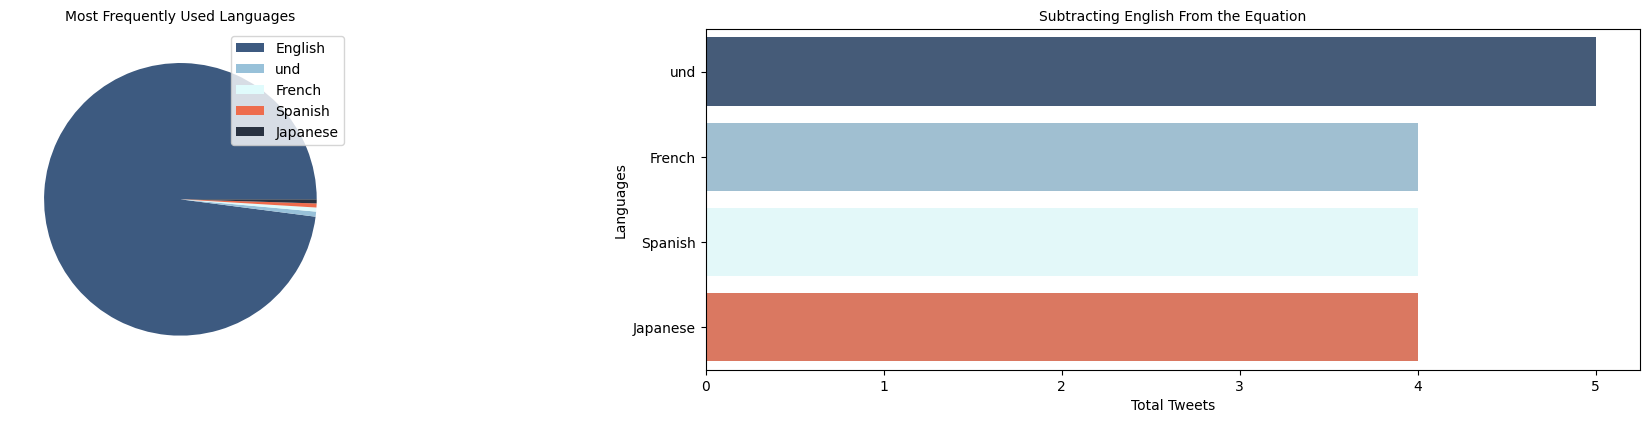

In [31]:
fig,ax = plt.subplots(ncols = 2, figsize = (20,4) , dpi = 100)
plt.tight_layout()
colors = ['#3d5a80', '#98c1d9' , '#e0fbfc' ,'#ee6c4d' , '#293241' , '#ffd92f','#e5c494']
language_series['Total Tweets'][:5].plot(kind = 'pie', labels = [' ',' ',' ',' ',' '], colors = colors[:5] , ax = ax[0])
sns.barplot(y = language_series['Languages'][1:5] , x = language_series['Total Tweets'][1:5] ,ax = ax[1], palette = colors[:4])
ax[0].set_ylabel('')
ax[0].legend(labels = language_series['Languages'])
ax[0].set_title('Most Frequently Used Languages' ,  fontsize = 10)
ax[1].set_title('Subtracting English From the Equation',fontsize = 10)

# **User Ids Of Top 20 Tweet Accounts 2010**

Text(0.5, 1.0, 'Top 20 Tweeters')

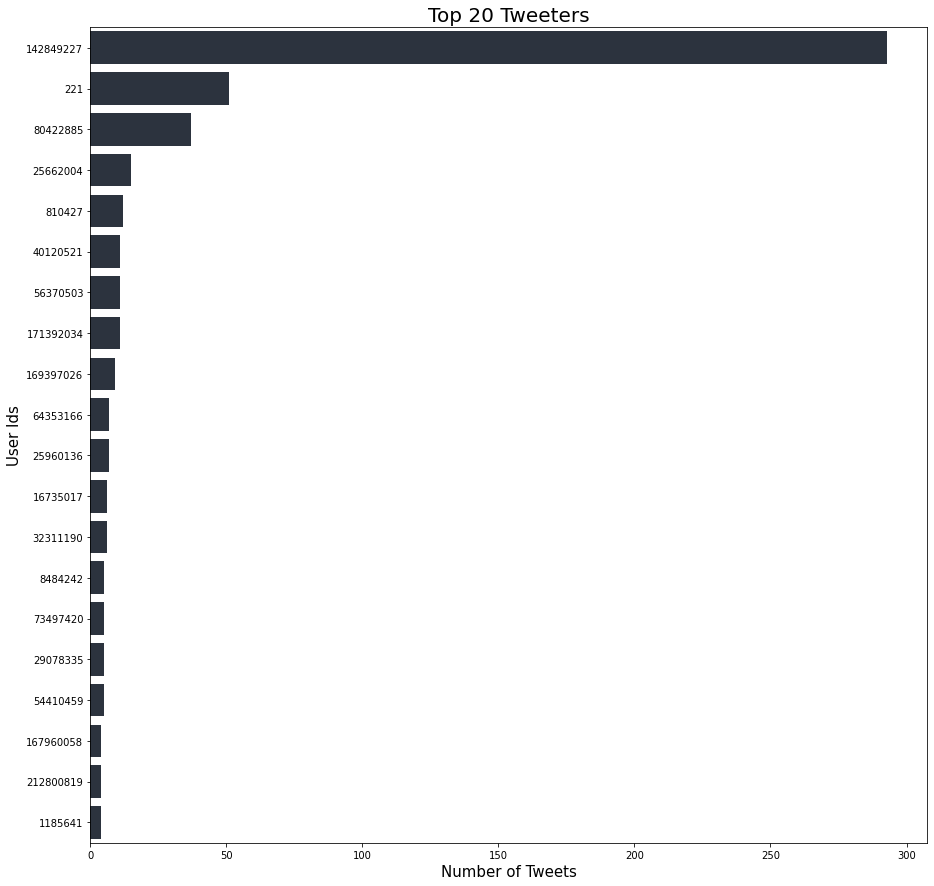

In [32]:
plt.figure(figsize=(15,15))
sns.barplot(y = [str(i) for i in data_2010['user_id'].unique()][:20] , x = data_2010['user_id'].value_counts().values[:20] , color = '#293241')
plt.ylabel('User Ids' , fontsize = 15)
plt.xlabel('Number of Tweets', fontsize = 15)
plt.title('Top 20 Tweeters' , fontsize = 20)

# **Monthly Count of Total Tweets 2010**

Text(0.5, 1.0, 'Count of Tweets Monthly')

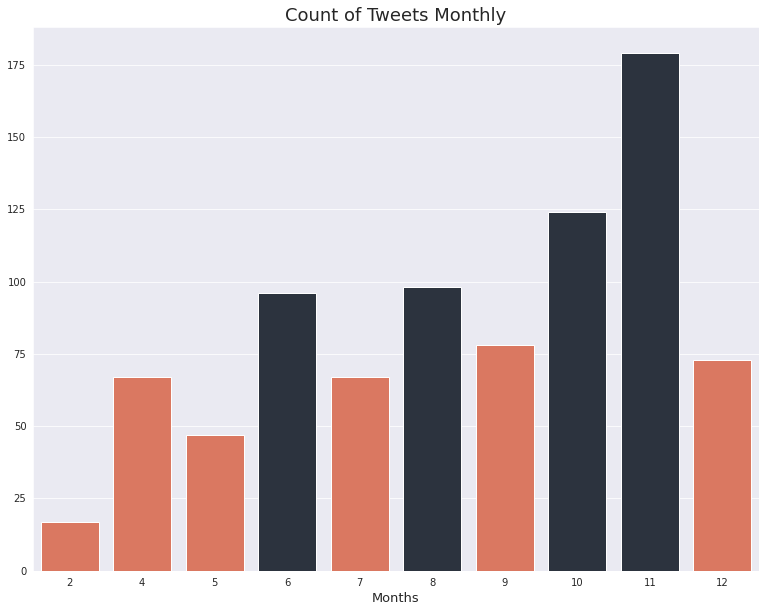

In [33]:
sns.set_style("darkgrid")
plt.figure(figsize = (13,10))
colors = ['#ee6c4d' for i in range(10)]
colors[3] = '#293241'
colors[5] = '#293241'
colors[7] = '#293241'
colors[8] = '#293241'
sns.countplot(data_2010['created_at'].dt.month , palette = colors)
plt.xlabel('Months',fontsize = 13)
plt.ylabel('')
plt.title('Count of Tweets Monthly',fontsize = 18)

The peak months were clearly Novemeber, October, August and June.

# **Total Tweets Segregated Hourwise 2010**

Text(0.5, 1.0, 'Count of Tweets Hourly')

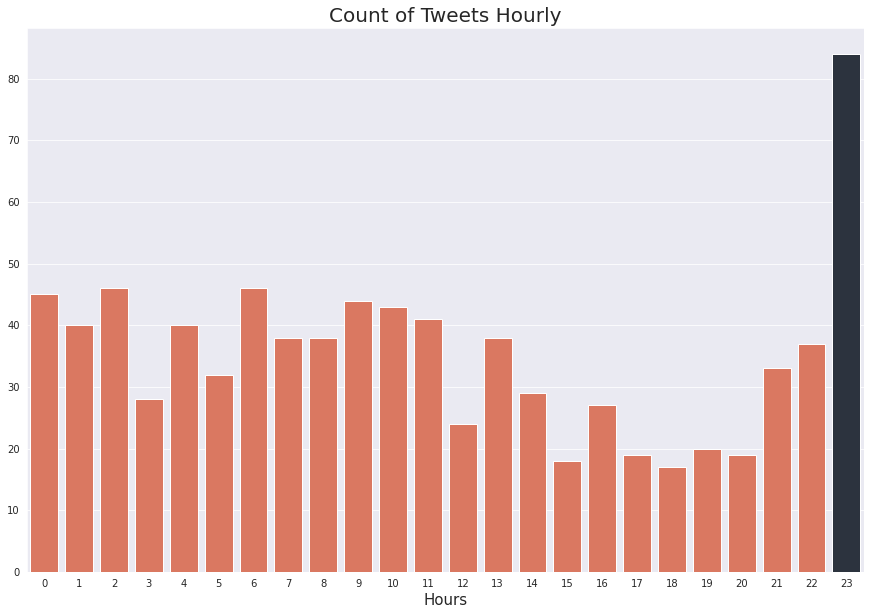

In [34]:
plt.figure(figsize = (15,10))
colors = ['#ee6c4d' for i in range(24)]
colors[23] = '#293241'
sns.countplot(data_2010['created_at'].dt.hour , palette = colors)
plt.xlabel('Hours',fontsize = 15)
plt.ylabel('')
plt.title('Count of Tweets Hourly',fontsize = 20)

Clearly, I am not alone in scrolling through social media at the wrong time. From this we can see that for most of the office hours that is 9am-5pm, the number of tweets are less as compared to the late hours at night. Especially 11 pm. We'll see if this trend is continued for the next years.

# **Top 30 Keywords From Tweets of 2010**

We can see that there are extremely few tweets in other languages , so just for now, in the rest of the notebook I  have provided the analysis on the basis of the tweets in english.

In [35]:
data_2010 = data_2010[data_2010['language'] == 'English']
data_2010['Clean Tweet'] = data_2010['tweet'].apply(clean_txt)
data_2010['Keywords'] = data_2010['Clean Tweet'].apply(get_keywords)
data_2010['Sentiment-Tweet'] = data_2010['tweet'].apply(get_sentiment)
data_2010.head()

,id,conversation_id,created_at,user_id,tweet,language,mentions,urls,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,Clean Tweet,Keywords,Sentiment-Tweet
0,20606088629981184,20606088629981184,2010-12-30 22:24:09+00:00,142849227,"Delicious: Data mining, forecasting and bioinf...",English,[],[],0,0,0,[],[],https://twitter.com/UXfeeder/status/2060608862...,False,delicious data mining bioinformatics competiti...,"[bioinformatics, httpwwwkagglecom, research, c...",1
1,20601892094607360,20601892094607360,2010-12-30 22:07:28+00:00,221,exploring kaggle's social network analysis cha...,English,[],[],0,0,0,[],[],https://twitter.com/h0mee/status/2060189209460...,False,kaggles looking predictions digraphs,"[kaggles, digraphs, predictions, looking]",1
2,20598958933934080,20598084153114624,2010-12-30 21:55:49+00:00,80422885,@iamreddave Indeed! Thanks for the pointer.,English,[],[],0,0,0,[],[],https://twitter.com/kaggle/status/205989589339...,False,indeed thanks pointer,"[thanks, pointer]",1
3,20598084153114624,20598084153114624,2010-12-30 21:52:20+00:00,25662004,@kaggle prizes are catching on http://www.sla...,English,[],[],0,0,0,[],[],https://twitter.com/iamreddave/status/20598084...,False,prizes httpwwwslatecomid,"[httpwwwslatecomid, prizes]",1
4,19424626304094209,19424626304094209,2010-12-27 16:09:26+00:00,810427,"""How I won the Chess Ratings Elo vs the Res...",English,[],[],0,0,0,"['chess', 'kaggle']",[],https://twitter.com/sixhat/status/194246263040...,False,how chess ratings elo rest world competition h...,"[chess, httpbitlygofqc, ratings, rest, competi...",0


In [36]:
keywords_2010 = get_keywords_ratings(data_2010).drop(columns = ['index'], axis=0)[:30]
keywords_2010

,Words,Frequency
0,kaggle,289
1,competitions,91
2,competition,46
3,mining,39
4,data,37
5,comp,33
6,kagglecom,31
7,bioinformatics,29
8,httpkagglecom,28
9,contest,24


Text(0.5, 1.0, 'Top 30 Keywords from Tweets of 2010')

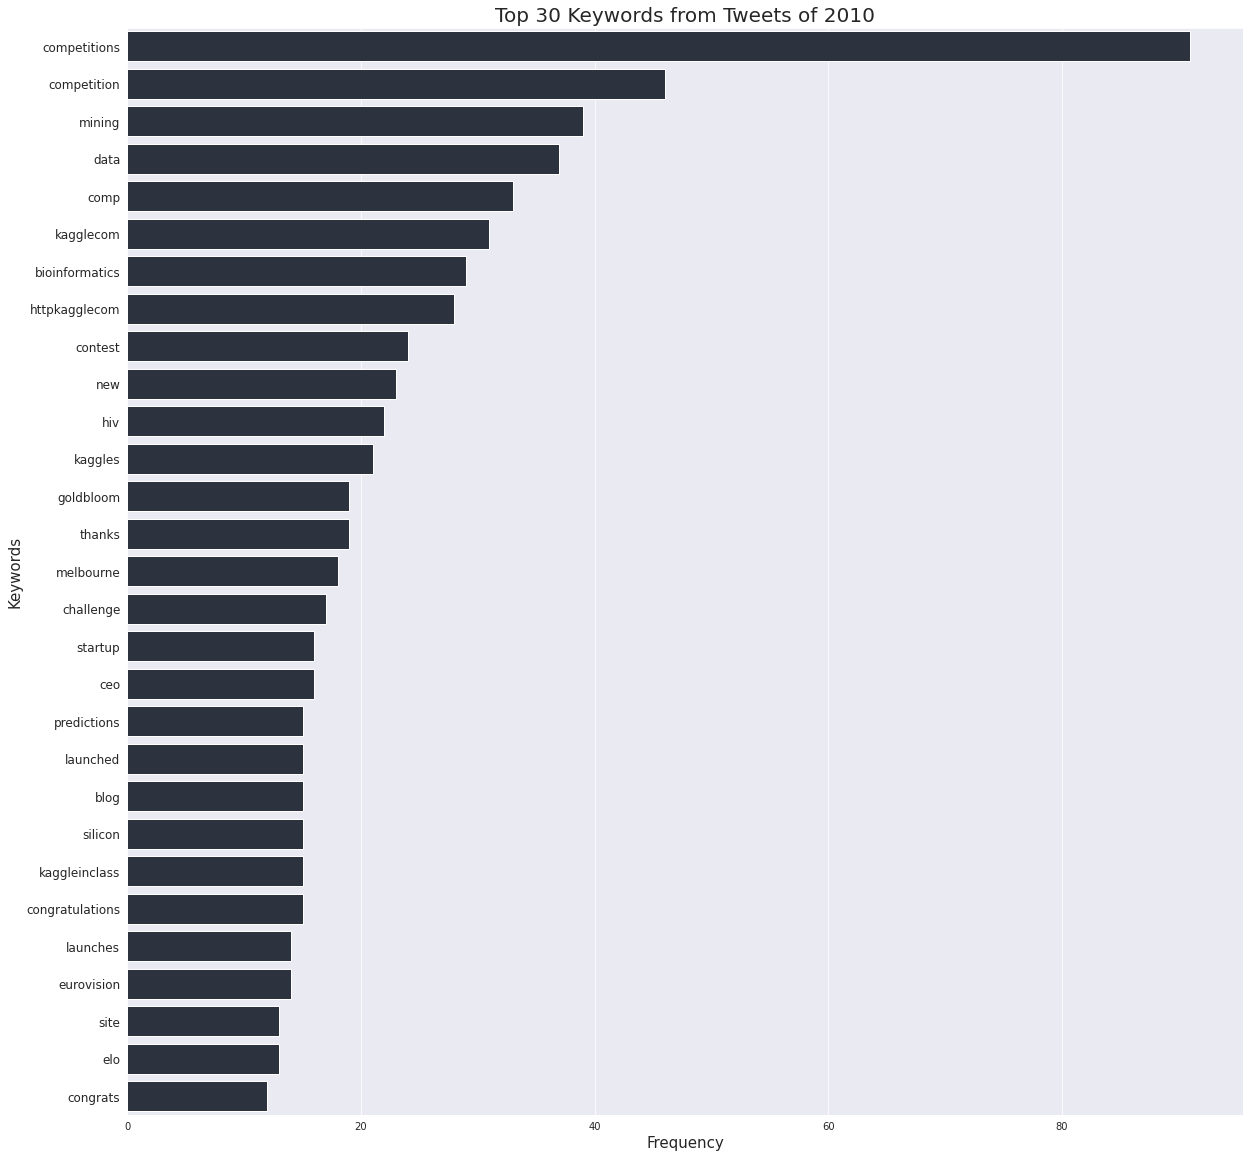

In [37]:
plt.figure(figsize = (20,20))
sns.barplot(y = keywords_2010['Words'][1:] , x = keywords_2010['Frequency'][1:] , color = '#293241')
plt.tick_params(axis = 'y',labelsize = 12)
plt.xlabel('Frequency', fontsize = 15)
plt.ylabel('Keywords' , fontsize = 15)
plt.title('Top 30 Keywords from Tweets of 2010' , fontsize = 20)

# **Topic Modelling using LDA 2010**

In [38]:
list_corpus,tfidf = vectorize(data_2010["Clean Tweet"].tolist())

colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:8]

In [39]:
n_topics = 8
lda_model = LatentDirichletAllocation(n_components=8, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(list_corpus)

lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

top_n_words_lda = get_top_n_words(10, lda_keys,list_corpus, tfidf)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  kaggle gov new melbourne open competition meetup goldbloom httpbitlybbfec projects
Topic 2:  leads ibm predicting datasets elo helps from httpbitlyadehva seasons reports
Topic 3:  kaggle competitions data mining bioinformatics httpkagglecom hiv competition contest stats
Topic 4:  kaggle gets site facelift data comments http netflix competitions startups
Topic 5:  httpkagglecomr what brainstorming httpbitlycvkkx has luck comp but package maybe
Topic 6:  thanks you are happens wrong valley silicon kaggle australia tnw
Topic 7:  ask questions great kaggleinclass kagglecom kaggle students httpbitlyush blog more
Topic 8:  kagglecom kaggles httpkagglecomworldcup kaggle not looking challenge challenges now predictions


# **Top 8 Topics Found Using LDA**

(array([2, 7, 5, 0, 4, 6, 1, 3]),
 [Text(2, 0, 'Topic 2: \nkaggle competitions data'),
  Text(7, 0, 'Topic 7: \nkagglecom kaggles httpkagglecomworldcup'),
  Text(5, 0, 'Topic 5: \nthanks you are'),
  Text(0, 0, 'Topic 0: \nkaggle gov new'),
  Text(4, 0, 'Topic 4: \nhttpkagglecomr what brainstorming'),
  Text(6, 0, 'Topic 6: \nask questions great'),
  Text(1, 0, 'Topic 1: \nleads ibm predicting'),
  Text(3, 0, 'Topic 3: \nkaggle gets site')])

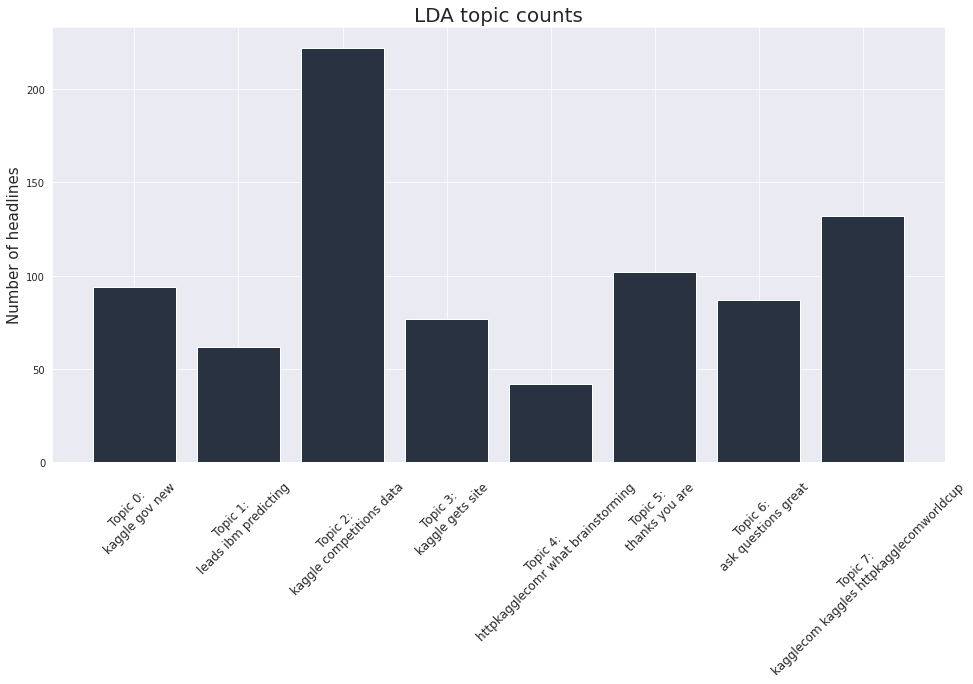

In [40]:
top_3_words = get_top_n_words(3, lda_keys, list_corpus, tfidf)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts , color = '#293241')
ax.tick_params(axis = 'x' , labelsize = 12)
ax.set_xticks(lda_categories)
ax.set_xticklabels(labels)
ax.set_title('LDA topic counts' , fontsize = 20)
ax.set_ylabel('Number of headlines', fontsize = 15)
plt.xticks(rotation = 45)



# **TSNE Representation Of Top 8 Topics Using LDA 2010**

In [41]:
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 818 samples in 0.001s...
[t-SNE] Computed neighbors for 818 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 818 / 818
[t-SNE] Mean sigma: 0.020064
[t-SNE] KL divergence after 250 iterations with early exaggeration: 40.529362
[t-SNE] KL divergence after 2000 iterations: 0.072399


In [42]:
top_3_words_lda = get_top_n_words(3, lda_keys, list_corpus, tfidf)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

# **Top Hashtags of The Year 2010**

Text(0.5, 1.0, 'Top 20 Hashtags from Tweets of 2010')

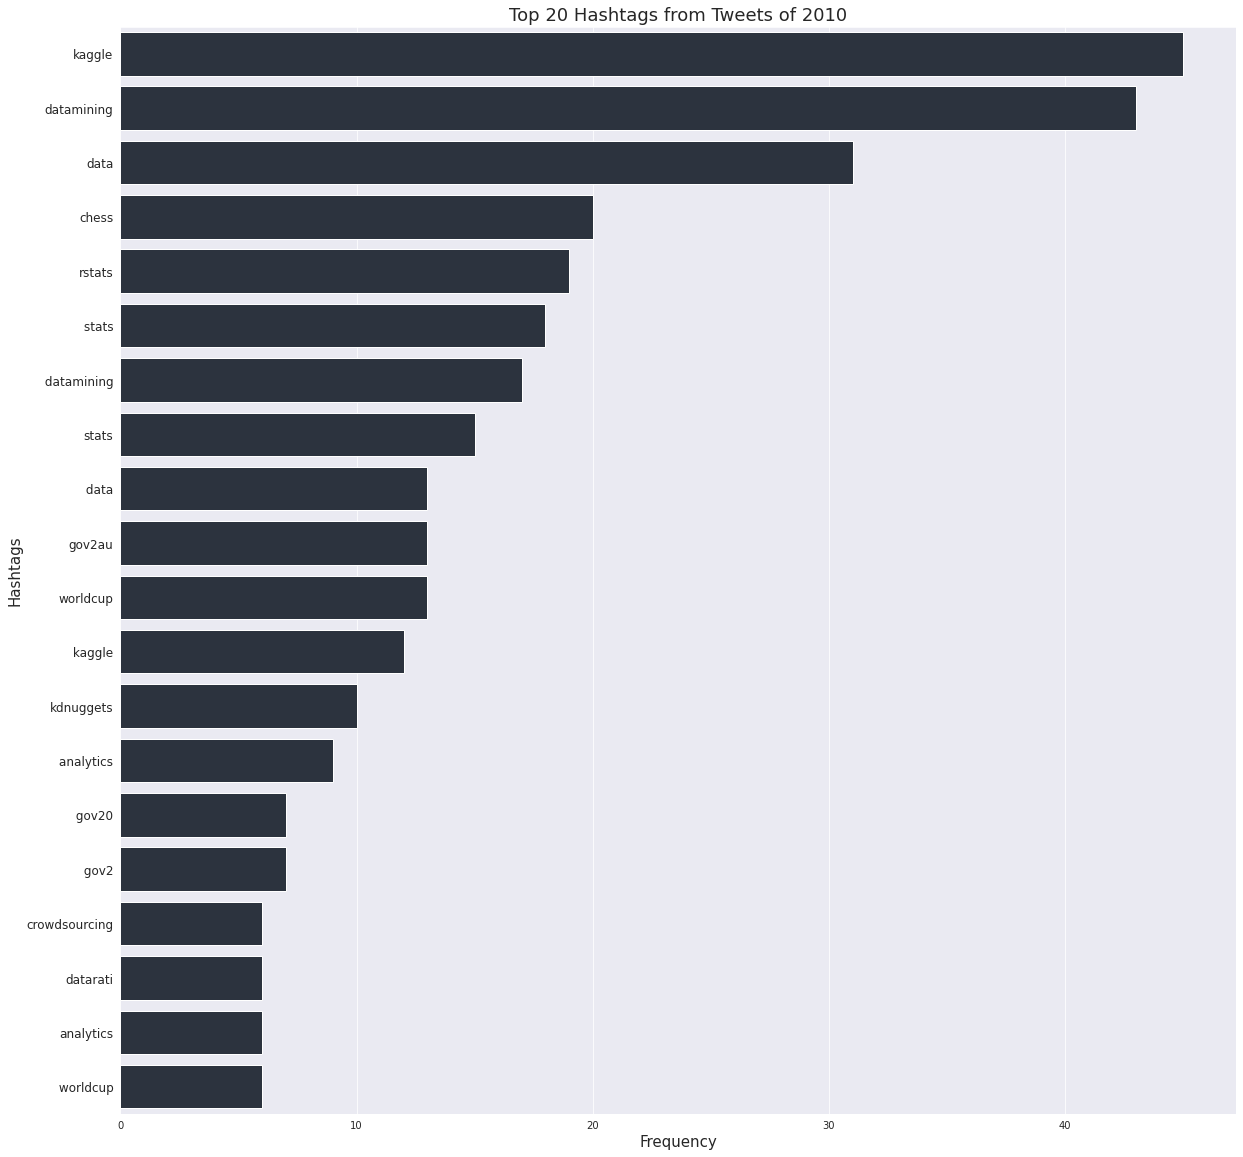

In [43]:
frequency_hashtags = get_frequency_hashtags(data_2010)[:20]
plt.figure(figsize = (20,20))
sns.barplot(y = frequency_hashtags['Hashtag'] , x = frequency_hashtags['Frequency'] , color = '#293241')
plt.tick_params(axis = 'y',labelsize = 12)
plt.ylabel('Hashtags' , fontsize = 15)
plt.xlabel('Frequency', fontsize = 15)
plt.title('Top 20 Hashtags from Tweets of 2010' , fontsize = 18)

# **Sentiment Analysis Of Tweets 2010**

Text(0.5, 1.0, 'Assigned Sentiment Distribution')

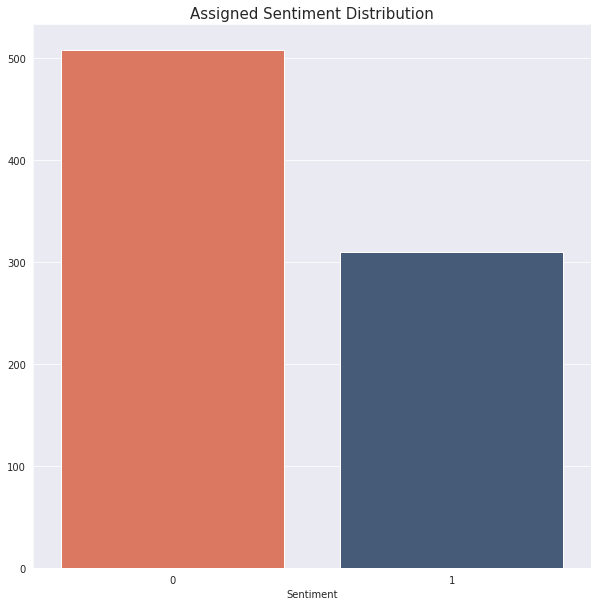

In [44]:
plt.figure(figsize = (10,10))
colors_senti = ['#ee6c4d' , '#3d5a80']
sns.countplot(data_2010['Sentiment-Tweet'], palette = colors_senti)
plt.xlabel('Sentiment',fontsize = 10)
plt.ylabel('')
plt.title('Assigned Sentiment Distribution',fontsize = 15)

In [45]:
positive_tweets = data_2010[data_2010['Sentiment-Tweet'] == 1]['Clean Tweet'].tolist()
positive_tweets = list(set(positive_tweets))
negative_tweets = data_2010[data_2010['Sentiment-Tweet'] == 0]['Clean Tweet'].tolist()
negative_tweets = list(set(negative_tweets))
common_words = list(set(positive_tweets)&set(negative_tweets))
positive_tweets = list(set(positive_tweets).difference(set(common_words)))
negative_tweets = list(set(negative_tweets).difference(set(common_words)))

# **Word Cloud For Positive Tweets 2010**

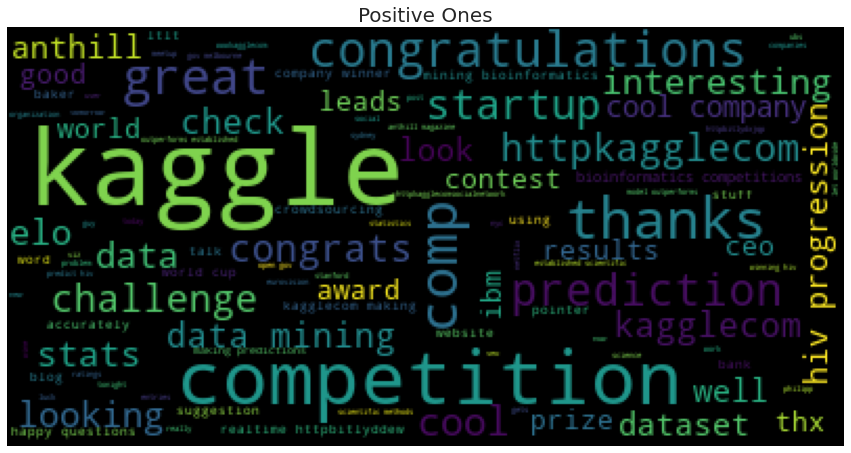

In [46]:
wc(positive_tweets,'black','Positive Ones')

# **Word Clouds for Negative Tweets 2010**

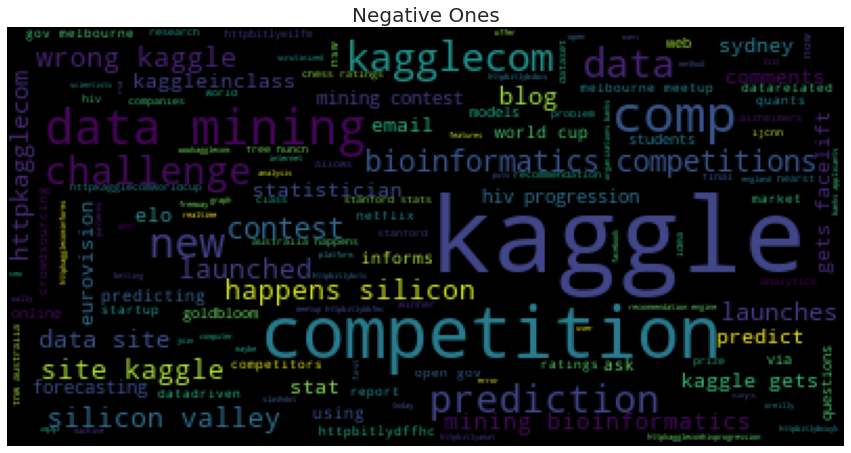

In [47]:
wc(negative_tweets,'black','Negative Ones')

# **Conclusion of 2010**



1. **Most Frequently Used Languages** 
    *  English is the most frequently used language as it appeared in more than 96% of Data, followed by an unknown language code 'und' which had only 5 tweets to its name.

2. **Top 20 Tweeters** 
    * I used User Ids instead of names for the sake of privacy. From the Graph , we can clearly see which user id was the most active on tweeting about Kaggle.

3. **Peak Months** 
    * The most tweets were recorded in the month of Novemeber , followed by October , August and June. Below I have discussed possible reasons for trends in these particular months:
        * November : The winners of the INFORMS Data Mining Contest were honoured in Austin, Texas in November in a huge event.
        * October : Results for INFORMS Data Mining Contest and HIV Progression Prediction Competition were announced. 
        * June : A Dataset was relased by JPMorgan and other leading Investment Banks on Kaggle , challenging Data Scientists to predict the winner for the 2010 Fifa World Cup.It was between 3th June - 6th June. The Fifa World Cup started on the 11th of June. 
        * I tried looking for explanation for the other months but couldn't find any , so far. Will Update once I find something.

4. **Most Frequent Hours for incoming Tweets**
    * The Twitter Data clearly shows that even a decade back , people were more active on twitter during Night Time. 
    *  The late night hours between 10 pm to 2 am have more high frequencies of tweets than any other period observed. 
    *  The period b/w 12pm to 8 pm registered the least amount of tweets. This could be because of the office hours.
    
5. **Top 30 Keywords** 
    * This list is topped by the word competition and is followed by words like data mining , bioinformatics , hiv and goldbloom.
    * The word data mining is in the top because of the INFORMS Data Mining Event , which I covered in the Peak Months.
    * Anthony Goldbloom is the CFO and CEO of Kaggle and Kaggle started in the year 2010.
    * Bioinformatics and HIV Progression were competitions which were launched by Kaggle.

6. **Topic Modelling**
    *  Through Topic Modelling few important topics of discussions were identified most of which were talks about competitions. They are as follows:
          * Melbourne : A competition for predicting the outcome of grants for University of Melbourne was launched.
          * HIV : I already discussed this.
          * Rest topics found were either a link to the Kaggle Website or a thanks statement or perhaps appreciation of any competition.     
          
7. **Top 30 Hashtags**
   * The top most hashtag was of course of the word kaggle . It was followed closely by other words such as chess , world cup , gov2au , kdnuggets , etc.
   * gov2au : Another Data Science Competition related to Travel Analysis was launched by the Government of Australia. People were tasked with predicting the Travel Time on Sydney's M4 freeway.

> In 2010 , when kaggle had just started , most of the people who tweeted about it were using english as a medium to share their experience. The incoming tweets were observed to increase when a new competition was launched and also , during late night hours. Most people used to tweet about an ongoing competition or perhaps something related to statistics as the word 'stats' came across a lot. If ,an overall image were to be formed for this year, it would probably have the names of the famous competitions in this year and a lot of congratulatory messages(which can be seen in the word cloud of 2010). This year can be called the year of competitions according to me.

> In 2021, the Japanese language was the language which was used more than often to share one's experience w.r.t kaggle. It was followed by English very closely. One cannot draw a conclusion or hypothesize any theory on the increase of tweets in a particular month as the months so far have been mostly neck to neck. The total number of incoming tweets increased by a huge margin and most of them seem to be coming in the time period of 8am to 4pm. Most of the people seem to be talking about learning , competitions and perhaps congratulating the newly annointed Grandmasters. The hastags also confirm this story as they seem to be dominated by challenges such as 100daysofml , which help people learn new things in the field of ML. Also, the topic of discussions have shifted from statistics to machine learning and AI.

 **So,one can say that 2010 was all really about the competitions held on kaggle and statistics, whereas 2021 has become all about learning new concepts,the titles of masters and grandmasters , competitions, Machine Learning and Artificial Intelligence.**

# **References**

[Topic Modelling ](https://www.kaggle.com/rcushen/topic-modelling-with-lsa-and-lda)